<a href="https://colab.research.google.com/github/MohmedAAK/Multi-filter-layer/blob/main/code/decreasing%20structure%20percentages.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install visualkeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.0/993.0 kB 21.1 MB/s eta 0:00:00


In [2]:
import tensorflow as tf

BN_AXIS = 3
DATA_FORMAT = 'channels_last'

def ResNet18(include_top=False, weights=None, input_shape=None, layer_params=[2, 2, 2, 2], pooling=None):
    input_shape = _obtain_input_shape(input_shape,
                                      default_size=224,
                                      min_size=32,
                                      data_format=DATA_FORMAT,
                                      require_flatten=include_top,
                                      weights=weights)

    img_input = tf.keras.layers.Input(shape=input_shape)


    x = tf.keras.layers.ZeroPadding2D(padding=(3, 3), name='conv1_pad')(img_input)
    x = tf.keras.layers.Conv2D(64, (7, 7),
                      strides=(2, 2),
                      padding='valid',
                      kernel_initializer='he_normal',
                      name='conv1')(x)
    x = tf.keras.layers.BatchNormalization(axis=BN_AXIS, name='bn_conv1')(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.ZeroPadding2D(padding=(1, 1), name='pool1_pad')(x)
    x = tf.keras.layers.MaxPooling2D((3, 3), strides=(2, 2))(x)


    x = make_basic_block_layer(x, filter_num=64,
                                    blocks=layer_params[0])
    x = make_basic_block_layer(x, filter_num=128,
                                         blocks=layer_params[1],
                                         stride=2)
    x = make_basic_block_layer(x, filter_num=256,
                                         blocks=layer_params[2],
                                         stride=2)
    x = make_basic_block_layer(x, filter_num=512,
                                         blocks=layer_params[3],
                                         stride=2)

    if pooling == 'avg':
        x = tf.keras.layers.GlobalAveragePooling2D()(x)
    elif pooling == 'max':
        x = tf.keras.layers.GlobalMaxPooling2D()(x)

    model = tf.keras.Model(img_input, x, name='resnet18')
    return model


def make_basic_block_base(inputs, filter_num, stride=1):
    x = tf.keras.layers.Conv2D(filters=filter_num,
                                        kernel_size=(3, 3),
                                        strides=stride,
                                        kernel_initializer='he_normal',
                                        padding="same")(inputs)
    x = tf.keras.layers.BatchNormalization(axis=BN_AXIS)(x)
    x = tf.keras.layers.Conv2D(filters=filter_num,
                                        kernel_size=(3, 3),
                                        strides=1,
                                        kernel_initializer='he_normal',
                                        padding="same")(x)
    x = tf.keras.layers.BatchNormalization(axis=BN_AXIS)(x)

    shortcut = inputs
    if stride != 1:
        shortcut = tf.keras.layers.Conv2D(filters=filter_num,
                                            kernel_size=(1, 1),
                                            strides=stride,
                                            kernel_initializer='he_normal')(inputs)
        shortcut = tf.keras.layers.BatchNormalization(axis=BN_AXIS)(shortcut)

    x = tf.keras.layers.add([x, shortcut])
    x = tf.keras.layers.Activation('relu')(x)

    return x

def make_basic_block_layer(inputs, filter_num, blocks, stride=1):
    x = make_basic_block_base(inputs, filter_num, stride=stride)

    for _ in range(1, blocks):
        x = make_basic_block_base(x, filter_num, stride=1)

    return x

def _obtain_input_shape(input_shape,
                        default_size,
                        min_size,
                        data_format,
                        require_flatten,
                        weights=None):
    """
    Private function taken from Tensorflow internal library.
    """
    if weights != 'imagenet' and input_shape and len(input_shape) == 3:
        if data_format == 'channels_first':
            default_shape = (input_shape[0], default_size, default_size)
        else:
            default_shape = (default_size, default_size, input_shape[-1])
    else:
        if data_format == 'channels_first':
            default_shape = (3, default_size, default_size)
        else:
            default_shape = (default_size, default_size, 3)
    if weights == 'imagenet' and require_flatten:
        if input_shape is not None:
            if input_shape != default_shape:
                raise ValueError('When setting `include_top=True` '
                                 'and loading `imagenet` weights, '
                                 '`input_shape` should be ' +
                                 str(default_shape) + '.')
        return default_shape
    if input_shape:
        if data_format == 'channels_first':
            if input_shape is not None:
                if len(input_shape) != 3:
                    raise ValueError(
                        '`input_shape` must be a tuple of three integers.')
                if input_shape[0] != 3 and weights == 'imagenet':
                    raise ValueError('The input must have 3 channels; got '
                                     '`input_shape=' + str(input_shape) + '`')
                if ((input_shape[1] is not None and input_shape[1] < min_size) or
                   (input_shape[2] is not None and input_shape[2] < min_size)):
                    raise ValueError('Input size must be at least ' +
                                     str(min_size) + 'x' + str(min_size) +
                                     '; got `input_shape=' +
                                     str(input_shape) + '`')
        else:
            if input_shape is not None:
                if len(input_shape) != 3:
                    raise ValueError(
                        '`input_shape` must be a tuple of three integers.')
                if input_shape[-1] != 3 and weights == 'imagenet':
                    raise ValueError('The input must have 3 channels; got '
                                     '`input_shape=' + str(input_shape) + '`')
                if ((input_shape[0] is not None and input_shape[0] < min_size) or
                   (input_shape[1] is not None and input_shape[1] < min_size)):
                    raise ValueError('Input size must be at least ' +
                                     str(min_size) + 'x' + str(min_size) +
                                     '; got `input_shape=' +
                                     str(input_shape) + '`')
    else:
        if require_flatten:
            input_shape = default_shape
        else:
            if data_format == 'channels_first':
                input_shape = (3, None, None)
            else:
                input_shape = (None, None, 3)
    if require_flatten:
        if None in input_shape:
            raise ValueError('If `include_top` is True, '
                             'you should specify a static `input_shape`. '
                             'Got `input_shape=' + str(input_shape) + '`')
    return input_shape

In [3]:
import cv2
import numpy as np
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
import tensorflow.keras
from tensorflow.keras.models import Sequential, Model,load_model
#from keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D,MaxPool2D,Concatenate
from tensorflow.keras.preprocessing import image
from tensorflow.keras.initializers import glorot_uniform

def Conv2D_M_filters_id(X_1,F,conv_name_base,pad,strid,mm1,mm2,mm3,count1,count2):
    f1=int(F*mm1)
    f2=int(int(F*mm2)*(1-(count2/count1)))
    f3=int(int(F*mm3)*(1-(count2/count1)))
    remain=F-(f1+f2+f3)
    f1+=remain
    X1=None
    X2=None
    if pad=='same':
            if f3!=0:
                X1= Conv2D(filters=f3, kernel_size=(7, 7), strides=strid, padding='same', name=conv_name_base +"2b2-7x7", kernel_initializer=glorot_uniform(seed=0))(X_1)
            if f2!=0:
                X2= Conv2D(filters=f2, kernel_size=(5, 5), strides=strid, padding='same', name=conv_name_base + '2b3-5x5', kernel_initializer=glorot_uniform(seed=0))(X_1)
            X3= Conv2D(filters=f1, kernel_size=(3, 3), strides=strid, padding='same', name=conv_name_base+"-3x3" , kernel_initializer=glorot_uniform(seed=0))(X_1)
    else:
        if strid==(1,1):
            if f3!=0:
                X1= Conv2D(filters=f3, kernel_size=(7, 7), strides=strid, padding='valid', name=conv_name_base + '2b2-7x7', kernel_initializer=glorot_uniform(seed=0))(X_1)
                X1=ZeroPadding2D(padding=2)(X1)
            if f2!=0:
                X2= Conv2D(filters=f2, kernel_size=(5, 5), strides=strid, padding='valid', name=conv_name_base + '2b3-5x5', kernel_initializer=glorot_uniform(seed=0))(X_1)
                X2=ZeroPadding2D(padding=1)(X2)
            X3= Conv2D(filters=f1, kernel_size=(3, 3), strides=strid, padding='valid', name=conv_name_base+"-3x3" , kernel_initializer=glorot_uniform(seed=0))(X_1)
        else:
            if f3!=0:
                X1= Conv2D(filters=f3, kernel_size=(7, 7), strides=strid, padding='valid', name=conv_name_base + '2b2-7x7', kernel_initializer=glorot_uniform(seed=0))(X_1)
                X1=ZeroPadding2D(padding=1)(X1)
            if f2!=0:
                X2= Conv2D(filters=f2, kernel_size=(5, 5), strides=strid, padding='valid', name=conv_name_base + '2b3-5x5', kernel_initializer=glorot_uniform(seed=0))(X_1)
                X2=ZeroPadding2D(padding=((0, 1), (0, 1)))(X2)#((top_pad, bottom_pad), (left_pad, right_pad))
            X3= Conv2D(filters=f1, kernel_size=(3, 3), strides=strid, padding='valid', name=conv_name_base+"-3x3" , kernel_initializer=glorot_uniform(seed=0))(X_1)

    if f3!=0:
        X=Concatenate(axis=-1)([X1,X2,X3])
    elif f2!=0:
        X=Concatenate(axis=-1)([X2,X3])
    else:
        X=X3
    return X
def insert_layer_nonseq(model, mm1,mm2,mm3,position='replace'):
    filter_name={}
    padding={}
    names=[]
    strid_={}
    count_lay=0
    for i in model.layers:
        layer_type = type(i).__name__
        if layer_type== 'Conv2D' and i.kernel_size == (3,3):
            count_lay+=1
            filter_name[i.name]=i.filters
            padding[i.name]=i.padding
            names.append(i.name)
            strid_[i.name]=i.strides
      # Auxiliary dictionary to describe the network graph
        network_dict = {'input_layers_of': {}, 'new_output_tensor_of': {}}

    # Set the input layers of each layer
    for layer in model.layers:
        for node in layer._outbound_nodes:
            layer_name = node.outbound_layer.name
            if layer_name not in network_dict['input_layers_of']:
                network_dict['input_layers_of'].update(
                        {layer_name: [layer.name]})
            else:
                network_dict['input_layers_of'][layer_name].append(layer.name)

    # Set the output tensor of the input layer
    network_dict['new_output_tensor_of'].update(
            {model.layers[0].name: model.input})

    # Iterate over all layers after the input
    x = None
    count_new_l=1
    for layer in model.layers[1:]:

        # Determine input tensors
        layer_input = [network_dict['new_output_tensor_of'][layer_aux]
                for layer_aux in network_dict['input_layers_of'][layer.name]]
        if len(layer_input) == 1:
            layer_input = layer_input[0]

        # Insert layer if name matches the regular expression
        if  layer.name in names :
            if position == 'replace':
                x = layer_input
            elif position == 'after':
                x = layer(layer_input)
            elif position == 'before':
                pass
            else:
                raise ValueError('position must be: before, after or replace')
            print(layer.filters,layer.strides,layer.padding,layer.kernel_size)
            new_layer = Conv2D_M_filters_id(x,filter_name[layer.name],layer.name,pad=padding[layer.name],strid=strid_[layer.name],mm1=mm1,mm2=mm2,mm3=mm3,count1=count_lay,count2=count_new_l)
            count_new_l+=1
            x = new_layer#(x)
            print('New layer: {} Old layer: {} Type: {}'.format(new_layer.name,
                                                            layer.name, position))
            if position == 'before':
                x = layer(x)
        else:
            x = layer(layer_input)

        # Set new output tensor (the original one, or the one of the inserted
        # layer)
        network_dict['new_output_tensor_of'].update({layer.name: x})

        # Save tensor in output list if it is output in initial model
        #if layer_name in model.output_names:
        #    model_outputs.append(x)

    return Model(inputs=model.inputs, outputs=x)

In [4]:
# Need this line so Google will recite some incantations
# for Turing to magically load the model onto the TPU
#with strategy.scope():
import tensorflow.keras.backend as K
from tensorflow.keras.applications import DenseNet201,DenseNet121,DenseNet169,ResNet152,ResNet101,ResNet50
import tensorflow as tf
rnet1=ResNet18(input_shape=(224, 224, 3),weights=None,include_top=False
              ,layer_params=[2, 2, 2, 2])
rnet2=ResNet18(input_shape=(224, 224, 3),weights=None,include_top=False
              ,layer_params=[3, 4, 6, 3])
rnet3 = ResNet50(input_shape=(224, 224, 3),weights=None,include_top=False)
rnet4 = ResNet101(input_shape=(224, 224, 3),weights=None,include_top=False)
rnet5 = ResNet152(input_shape=(224, 224, 3),weights=None,include_top=False)
models=[rnet1,rnet2,rnet3,rnet4,rnet5]

#
rnet=models[0]
model1 = tf.keras.Sequential([
    rnet,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(7, activation='softmax')
])
#rnet.save_weights("we.h5")
rnet=insert_layer_nonseq(rnet,0.75,0.20,0.05)
#rnet.load_weights("we.h5",by_name=True,skip_mismatch=True)
model2 = tf.keras.Sequential([
    rnet,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(7, activation='softmax')
])

model1.summary()
model2.summary()

64 (1, 1) same (3, 3)
New layer: concatenate/concat:0 Old layer: conv2d Type: replace
64 (1, 1) same (3, 3)
New layer: concatenate_1/concat:0 Old layer: conv2d_1 Type: replace
64 (1, 1) same (3, 3)
New layer: concatenate_2/concat:0 Old layer: conv2d_2 Type: replace
64 (1, 1) same (3, 3)
New layer: concatenate_3/concat:0 Old layer: conv2d_3 Type: replace
128 (2, 2) same (3, 3)
New layer: concatenate_4/concat:0 Old layer: conv2d_4 Type: replace
128 (1, 1) same (3, 3)
New layer: concatenate_5/concat:0 Old layer: conv2d_5 Type: replace
128 (1, 1) same (3, 3)
New layer: concatenate_6/concat:0 Old layer: conv2d_7 Type: replace
128 (1, 1) same (3, 3)
New layer: concatenate_7/concat:0 Old layer: conv2d_8 Type: replace
256 (2, 2) same (3, 3)
New layer: concatenate_8/concat:0 Old layer: conv2d_9 Type: replace
256 (1, 1) same (3, 3)
New layer: concatenate_9/concat:0 Old layer: conv2d_10 Type: replace
256 (1, 1) same (3, 3)
New layer: concatenate_10/concat:0 Old layer: conv2d_12 Type: replace
256 

In [5]:
trainable_count1 = np.sum([K.count_params(w) for w in model1.trainable_weights])
trainable_count2 = np.sum([K.count_params(w) for w in model2.trainable_weights])
print(trainable_count1,trainable_count2)
print(((trainable_count2-trainable_count1)/trainable_count1)*100)

11184903 12112647
8.294609260357467


In [6]:
def fun(id):
    if id==1:
        rnet1=ResNet18(input_shape=(224, 224, 3),weights=None,include_top=False
              ,layer_params=[2, 2, 2, 2])
        return rnet1
    if id==2:
        rnet2=ResNet18(input_shape=(224, 224, 3),weights=None,include_top=False
              ,layer_params=[3, 4, 6, 3])
        return rnet2
    if id==3:
        rnet3 = ResNet50(input_shape=(224, 224, 3),weights=None,include_top=False)
        return rnet3
    if id==4:
        rnet4 = ResNet101(input_shape=(224, 224, 3),weights=None,include_top=False)
        return rnet4
    if id==5:
        rnet5 = ResNet152(input_shape=(224, 224, 3),weights=None,include_top=False)
        return rnet5

In [7]:
rnet1=ResNet18(input_shape=(224, 224, 3),weights=None,include_top=False
              ,layer_params=[2, 2, 2, 2])
rnet2=ResNet18(input_shape=(224, 224, 3),weights=None,include_top=False
              ,layer_params=[3, 4, 6, 3])
rnet3 = ResNet50(input_shape=(224, 224, 3),weights=None,include_top=False)
rnet4 = ResNet101(input_shape=(224, 224, 3),weights=None,include_top=False)
rnet5 = ResNet152(input_shape=(224, 224, 3),weights=None,include_top=False)
models=[rnet1,rnet2,rnet3,rnet4,rnet5]

In [8]:
layers=[18,34,50,101,152]
lay=[]
percent_f=[]
percent_inc=[]
for k in range(len(models)):
    print("model",layers[k])
    for i in range(50,101,1):

        mm1=i/100
        mm2=(1-mm1)*(0.65)
        mm3=1-mm1-mm2
        rnet=tf.keras.models.clone_model(models[k])
        model1 = tf.keras.Sequential([
            rnet,
            tf.keras.layers.GlobalAveragePooling2D(),
            tf.keras.layers.Dense(7, activation='softmax')
        ])
        #rnet.save_weights("we.h5")
        rnet=insert_layer_nonseq(rnet,mm1,mm2,mm3)
        #rnet.load_weights("we.h5",by_name=True,skip_mismatch=True)
        model2 = tf.keras.Sequential([
            rnet,
            tf.keras.layers.GlobalAveragePooling2D(),
            tf.keras.layers.Dense(7, activation='softmax')
        ])
        trainable_count1 = np.sum([K.count_params(w) for w in model1.trainable_weights])
        trainable_count2 = np.sum([K.count_params(w) for w in model2.trainable_weights])
        precent=((trainable_count2-trainable_count1)/trainable_count1)*100
        lay.append(layers[k])
        percent_f.append(i)
        percent_inc.append(precent)
        print("precnet",i,"inc",precent)

Streaming output truncated to the last 5000 lines.
256 (1, 1) same (3, 3)
New layer: concatenate_4509/concat:0 Old layer: conv4_block15_2_conv Type: replace
256 (1, 1) same (3, 3)
New layer: concatenate_4510/concat:0 Old layer: conv4_block16_2_conv Type: replace
256 (1, 1) same (3, 3)
New layer: concatenate_4511/concat:0 Old layer: conv4_block17_2_conv Type: replace
256 (1, 1) same (3, 3)
New layer: concatenate_4512/concat:0 Old layer: conv4_block18_2_conv Type: replace
256 (1, 1) same (3, 3)
New layer: concatenate_4513/concat:0 Old layer: conv4_block19_2_conv Type: replace
256 (1, 1) same (3, 3)
New layer: concatenate_4514/concat:0 Old layer: conv4_block20_2_conv Type: replace
256 (1, 1) same (3, 3)
New layer: concatenate_4515/concat:0 Old layer: conv4_block21_2_conv Type: replace
256 (1, 1) same (3, 3)
New layer: concatenate_4516/concat:0 Old layer: conv4_block22_2_conv Type: replace
256 (1, 1) same (3, 3)
New layer: concatenate_4517/concat:0 Old layer: conv4_block23_2_conv Type: rep

In [9]:
rnet1 = DenseNet121(input_shape=(224, 224, 3),weights=None,include_top=False)
rnet2 = DenseNet169(input_shape=(224, 224, 3),weights=None,include_top=False)
rnet3 = DenseNet201(input_shape=(224, 224, 3),weights=None,include_top=False)
models=[rnet1,rnet2,rnet3]

In [10]:
layers=[121,169,201]
for k in range(len(models)):
    print("model",layers[k])
    for i in range(50,101,1):

        mm1=i/100
        mm2=(1-mm1)*(0.65)
        mm3=1-mm1-mm2
        rnet=tf.keras.models.clone_model(models[k])
        model1 = tf.keras.Sequential([
            rnet,
            tf.keras.layers.GlobalAveragePooling2D(),
            tf.keras.layers.Dense(7, activation='softmax')
        ])
        #rnet.save_weights("we.h5")
        rnet=insert_layer_nonseq(rnet,mm1,mm2,mm3)
        #rnet.load_weights("we.h5",by_name=True,skip_mismatch=True)
        model2 = tf.keras.Sequential([
            rnet,
            tf.keras.layers.GlobalAveragePooling2D(),
            tf.keras.layers.Dense(7, activation='softmax')
        ])
        trainable_count1 = np.sum([K.count_params(w) for w in model1.trainable_weights])
        trainable_count2 = np.sum([K.count_params(w) for w in model2.trainable_weights])
        precent=((trainable_count2-trainable_count1)/trainable_count1)*100
        lay.append(layers[k])
        percent_f.append(i)
        percent_inc.append(precent)
        print("precnet",i,"inc",precent)

Streaming output truncated to the last 5000 lines.
32 (1, 1) same (3, 3)
New layer: concatenate_13332/concat:0 Old layer: conv4_block44_2_conv Type: replace
32 (1, 1) same (3, 3)
New layer: concatenate_13333/concat:0 Old layer: conv4_block45_2_conv Type: replace
32 (1, 1) same (3, 3)
New layer: concatenate_13334/concat:0 Old layer: conv4_block46_2_conv Type: replace
32 (1, 1) same (3, 3)
New layer: concatenate_13335/concat:0 Old layer: conv4_block47_2_conv Type: replace
32 (1, 1) same (3, 3)
New layer: concatenate_13336/concat:0 Old layer: conv4_block48_2_conv Type: replace
32 (1, 1) same (3, 3)
New layer: concatenate_13337/concat:0 Old layer: conv5_block1_2_conv Type: replace
32 (1, 1) same (3, 3)
New layer: concatenate_13338/concat:0 Old layer: conv5_block2_2_conv Type: replace
32 (1, 1) same (3, 3)
New layer: concatenate_13339/concat:0 Old layer: conv5_block3_2_conv Type: replace
32 (1, 1) same (3, 3)
New layer: concatenate_13340/concat:0 Old layer: conv5_block4_2_conv Type: replace

In [11]:
import pandas as pd
# Calling DataFrame constructor after zipping
# both lists, with columns specified
df = pd.DataFrame(list(zip(lay, percent_f,percent_inc)),
               columns =['layers', 'percentage3x3',"percentage_increase"])

In [12]:
df.to_csv('decrease_models_percentage.csv')

In [13]:
from numpy.lib.arraypad import pad
model = Sequential()
model.add(Input((224, 224, 3)))
model.add(Conv2D(64, (5, 5), padding='same',activation='relu',name="conv2d_3x3"))
model.add(Flatten())
model.add(Dense(2, activation='softmax'))

In [14]:
x1 = model.layers[-1].output
model = Model(inputs = model.input, outputs = x1)

In [15]:
F=64
f1=int(F*0.75)
f2=int(F*0.20)
f3=int(F*0.05)
X_input = Input((224, 224, 3))
X1= Conv2D(filters=f3, kernel_size=(7, 7),activation='relu' , padding='same',name="conv2d_7x7")(X_input)
X2= Conv2D(filters=f2, kernel_size=(5, 5),activation='relu', padding='same' ,name="conv2d_5x5")(X_input)
X3= Conv2D(filters=f1, kernel_size=(3, 3),activation='relu', padding='same' ,name="conv2d_3x3")(X_input)
X=Concatenate(axis=-1)([X1,X2,X3])
X=Flatten()(X)
X=Dense(2, activation='softmax')(X)

In [16]:
model_ = Model(inputs = X_input, outputs = X )

In [17]:
#x1 = model.layers[-1].output
#model = Model(inputs = model.input, outputs = x1)

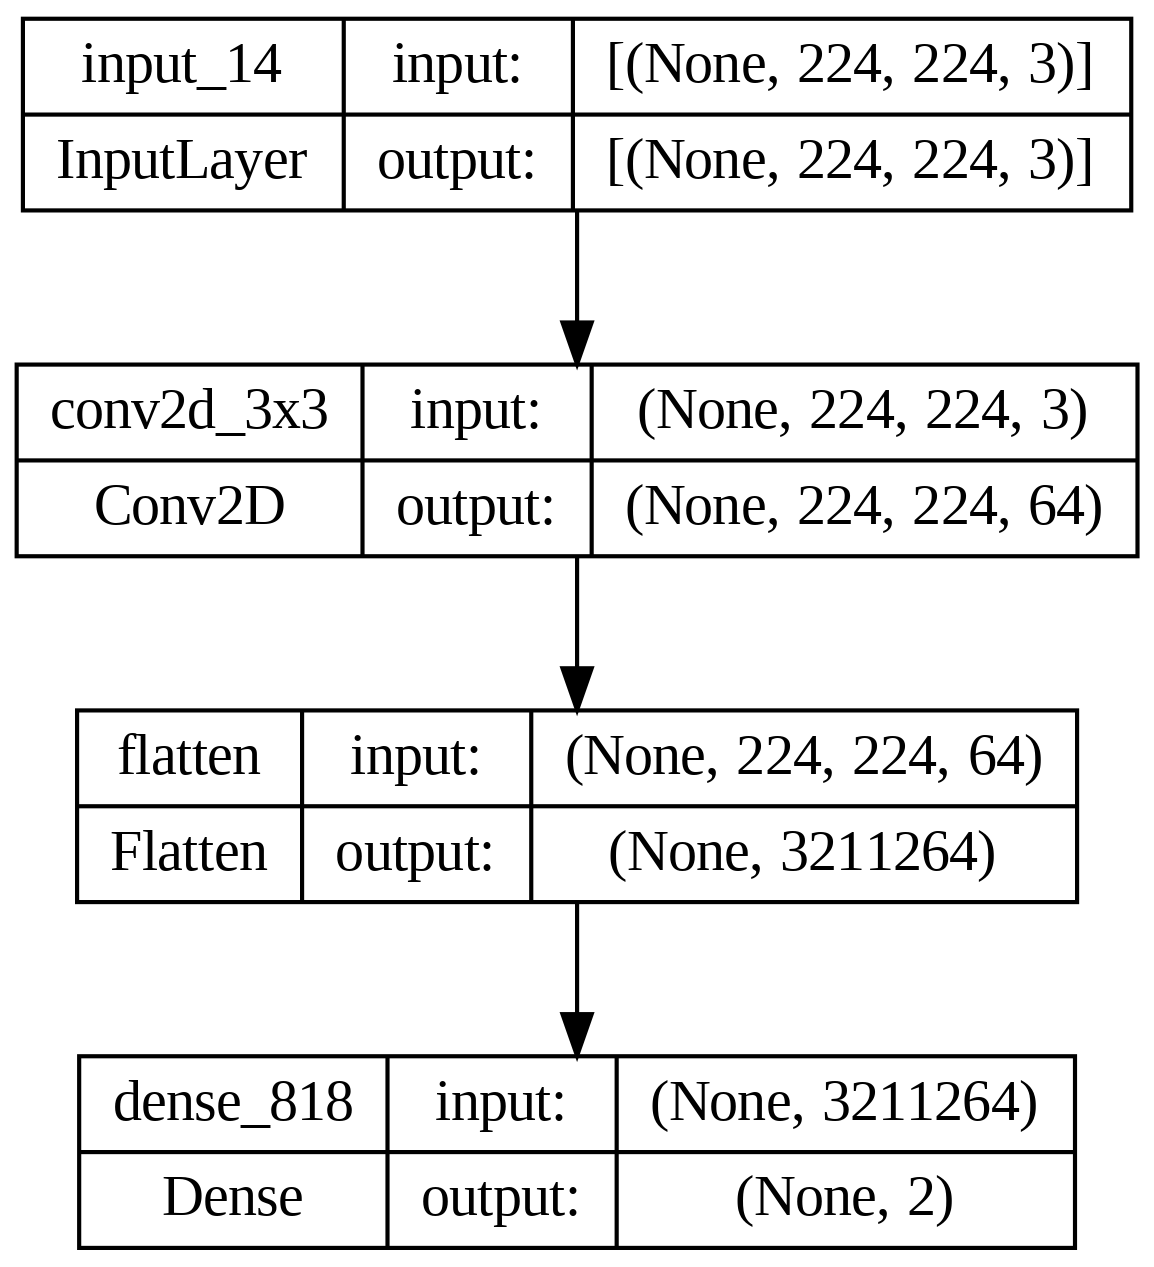

In [18]:
from keras.models import Sequential
from keras.layers import Dense
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_before.png', show_shapes=True, show_layer_names=True,dpi=300)

In [19]:
# Import pandas
import pandas as pd
# reading csv file
df=pd.read_csv("/content/decrease_models_percentage.csv")
df=df[['layers', 'percentage3x3',"percentage_increase"]]
df

,layers,percentage3x3,percentage_increase
0,18,50,20.599195
1,18,51,19.976642
2,18,52,19.564658
3,18,53,19.381554
4,18,54,19.029079
...,...,...,...
403,201,96,0.017320
404,201,97,0.017320
405,201,98,0.017320
406,201,99,0.017320


In [20]:
df_res_den=df[df['layers'] >40 ]

# replacing value of DataFrame
df_res_den.layers[df_res_den.layers == 50] = 'ResNet50'
df_res_den.layers[df_res_den.layers == 101] = 'ResNet101'
df_res_den.layers[df_res_den.layers == 152] = 'ResNet152'
df_res_den.layers[df_res_den.layers == 121] = 'DenseNet121'
df_res_den.layers[df_res_den.layers == 169] = 'DenseNet169'
df_res_den.layers[df_res_den.layers == 201] = 'DenseNet201'

<ipython-input-20-20198be6136a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_res_den.layers[df_res_den.layers == 50] = 'ResNet50'
<ipython-input-20-20198be6136a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_res_den.layers[df_res_den.layers == 50] = 'ResNet50'
<ipython-input-20-20198be6136a>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_res_den.layers[df_res_den.layers == 101] = 'ResNet101'
<ipython-input-20-20198be6

In [21]:
df_res=df[df['layers'] <155 ]
df_res=df_res[df_res['layers'] !=121 ]
df_res=df_res[df_res['layers'] >40 ]

In [22]:
df_dens=df[df['layers'] >120 ]
df_dens=df_dens[df_dens['layers'] !=152 ]

In [23]:
set(list(df_res.layers))

{50, 101, 152}

In [24]:
set(list(df_dens.layers))

{121, 169, 201}

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D
# Plot using `.trisurf()`:
fig = plt.figure()
ax = Axes3D(fig)
ax.plot_trisurf(df_res.layers, df_res.percentage3x3, df_res.percentage_increase, cmap=cm.jet, linewidth=0.2)


<Figure size 640x480 with 0 Axes>

In [26]:
!pip install seaborn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


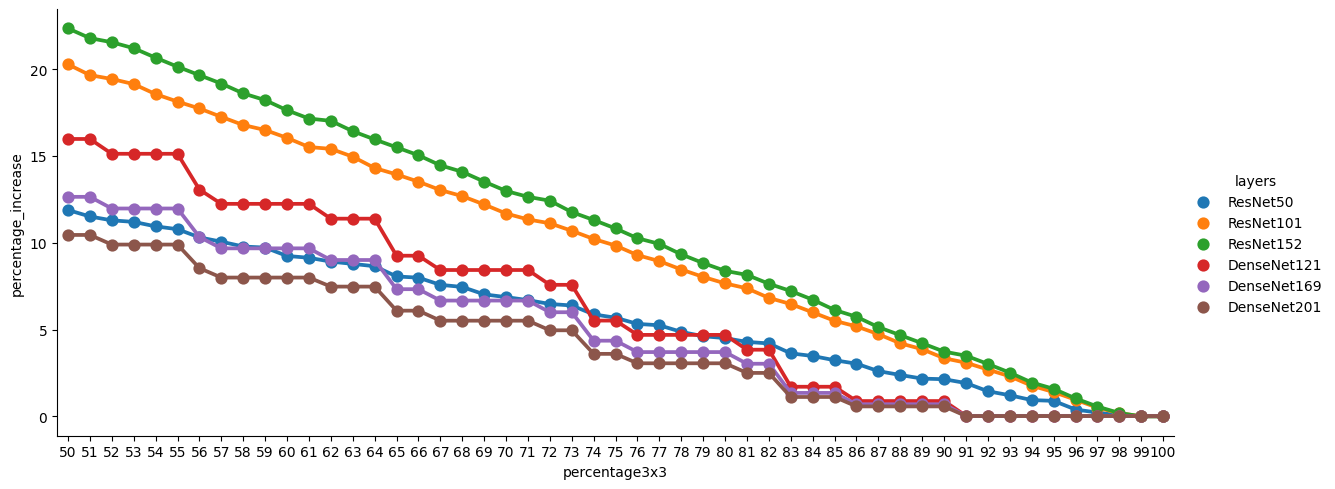

In [27]:
import pandas as pd
import seaborn as sns
import matplotlib.ticker as ticker
g = sns.catplot(x="percentage3x3", y="percentage_increase", hue='layers', data=df_res_den, kind='point',aspect=2.4)
g.figure.savefig('output_figure.png',dpi=600)